# MILESTONE 5

# task 1, 2, 3

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import wandb
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import string # for milestone 1
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


from datasets import Dataset, DatasetDict
from transformers import (
        AutoTokenizer, 
        AutoModelForSequenceClassification,
        TrainingArguments,
        Trainer,
        EarlyStoppingCallback
    )

from kaggle_secrets import UserSecretsClient # For secure API key access

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ["TOKENIZERS_PARALLELISM"] = "false" # getting rid of hugging face tokenizer parallelism warnings
os.environ["WANDB_SILENT"] = "true" # getting rid of wandb warnings about api keys, etc.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2025-sep-dl-gen-ai-project/sample_submission.csv
/kaggle/input/2025-sep-dl-gen-ai-project/train.csv
/kaggle/input/2025-sep-dl-gen-ai-project/test.csv


--- Section 1: Configuration ---

--- Section 2: Load and Prepare Data ---
Training split shape: (5461, 8)
Validation split shape: (1366, 8)

--- Task 3: Calculating pos_weight vector ---
1) pos_weight vector: [7.440494590417311, 0.7604771115409413, 3.078416728902166, 2.1385057471264366, 2.3898199875853505]


--- Section 3: Tokenization & Preprocessing ---
Tokenizing datasets...


Map:   0%|          | 0/5461 [00:00<?, ? examples/s]

Map:   0%|          | 0/1366 [00:00<?, ? examples/s]

Map:   0%|          | 0/1707 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Section 4: Model, Metrics, and Trainer Setup ---
Loading model: bert-base-uncased
Setting up training arguments...
Using Custom WeightedLossTrainer for Task 3.

--- Section 5: Starting Model Training (with Weighted Loss) ---


Epoch,Training Loss,Validation Loss,Macro F1
1,No log,0.919432,0.394997
2,No log,0.643269,0.679829
3,0.785000,0.519903,0.730376
4,0.785000,0.481978,0.779001


Training finished.
Best validation Macro F1 (from trainer): 0.7790

--- Section 6: Analysis (Task 1, 2, & 3) ---
Getting predictions from validation set...



--- Task 2 & 3: Threshold Tuning & Weighted Loss Analysis ---

2) Macro F1 with 0.5 threshold (pre-tuning): 0.7790
   Per-label F1 (0.5 thresh): [0.7324 0.8153 0.7851 0.7757 0.7865]

Searching for best threshold for each label...


 20%|██        | 1/5 [00:00<00:00,  5.93it/s]

  anger: Best F1=0.7692 at threshold=0.6864


 40%|████      | 2/5 [00:00<00:00,  6.81it/s]

  fear: Best F1=0.8249 at threshold=0.5864


 60%|██████    | 3/5 [00:00<00:00,  6.70it/s]

  joy: Best F1=0.7982 at threshold=0.5864


 80%|████████  | 4/5 [00:00<00:00,  6.46it/s]

  sadness: Best F1=0.7891 at threshold=0.6227


100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

  surprise: Best F1=0.7956 at threshold=0.6227

1) Tuned thresholds: [0.6863636363636364, 0.5863636363636364, 0.5863636363636364, 0.6227272727272728, 0.6227272727272728]

3) Macro F1 with tuned thresholds (post-tuning): 0.7954
   Per-label F1 (tuned thresh): [0.7692 0.8249 0.7982 0.7891 0.7956]


--- Task 3: Analysis ---
To answer the task questions, please compare the 'Per-label F1' scores
from this run (with weighted loss) to the scores from your
previous run (Task 2, without weighted loss).

The pos_weight vector was printed in Section 2.

--- Task 1: PR Curve Plotting ---
  anger - Average Precision (AP): 0.7697
  fear - Average Precision (AP): 0.8996
  joy - Average Precision (AP): 0.8660
  sadness - Average Precision (AP): 0.8514
  surprise - Average Precision (AP): 0.8594


PR curve plot saved as pr_curves.png
You can view the plot in the Kaggle output directory.

--- Section 7: Generating Submission File ---
Using TUNED thresholds for submission...


Applying optimal thresholds to test predictions...
  Applying anger threshold: 0.6864
  Applying fear threshold: 0.5864
  Applying joy threshold: 0.5864
  Applying sadness threshold: 0.6227
  Applying surprise threshold: 0.6227
Submission file created: submission.csv

Run complete.


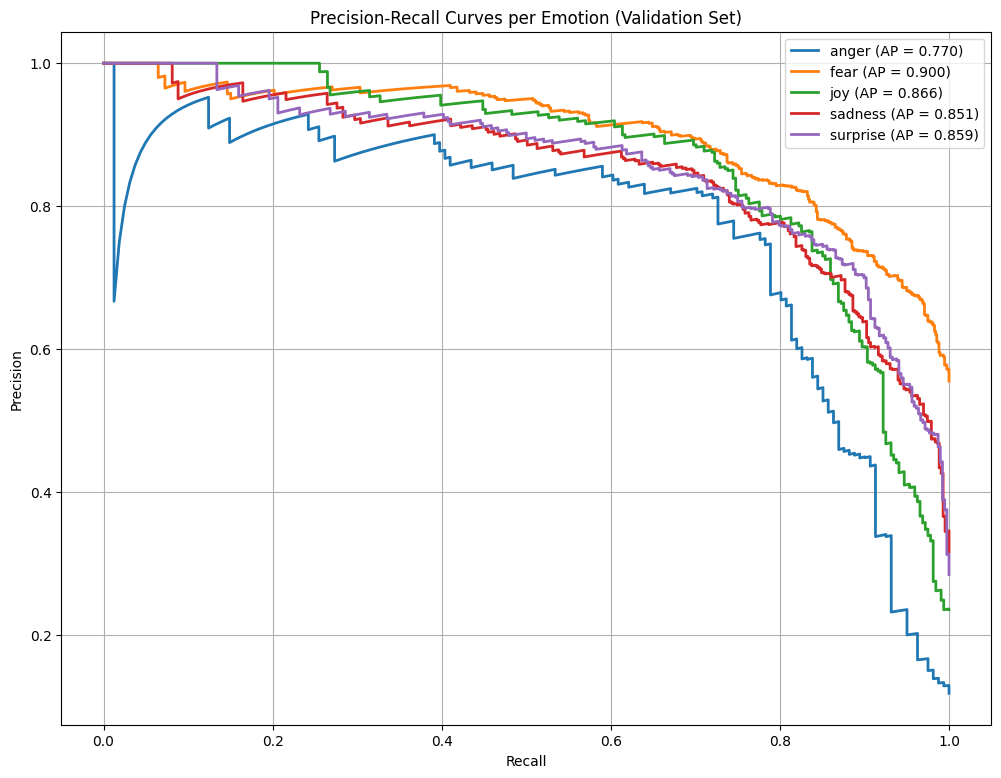

In [26]:
"""
This script fine-tunes a simple BERT-base model for multi-label emotion
classification and then performs detailed analysis for Tasks 1, 2, and 3.

This version does NOT use Weights & Biases.

It performs the following steps:
1.  Loads competition data.
2.  Creates an 80/20 train/validation split.
3.  TASK 3: Calculates 'pos_weight' vector for weighted loss.
4.  Tokenizes and preprocesses the text data.
5.  Loads and trains a 'bert-base-uncased' model using a
    CUSTOM TRAINER with weighted loss (BCEWithLogitsLoss).
6.  TASK 1: Gets validation probabilities, plots a 5-label PR curve,
    computes AP for each label, and saves the plot as 'pr_curves.png'.
7.  TASK 2: Finds optimal F1-thresholds for each label on the
    validation set and reports pre- and post-tuning Macro F1 scores.
8.  Generates a 'submission.csv' file using the tuned thresholds.
"""

import os
import pandas as pd
import numpy as np
import torch
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm # Import tqdm for progress bars

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# Suppress Hugging Face's tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Suppress the PyTorch UserWarning
warnings.filterwarnings(
    "ignore", 
    message="Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector."
)

# --- 1. Configuration ---
print("--- Section 1: Configuration ---")

config = {
    "MODEL_NAME": "bert-base-uncased",
    "TRAIN_FILE": "/kaggle/input/2025-sep-dl-gen-ai-project/train.csv",
    "TEST_FILE": "/kaggle/input/2025-sep-dl-gen-ai-project/test.csv",
    "EPOCHS": 4,
    "LEARNING_RATE": 2e-5,
    "TRAIN_BATCH_SIZE": 16,
    "EVAL_BATCH_SIZE": 32,
    "CLASSIFIER_DROPOUT": 0.1,
    "VALIDATION_SPLIT_SIZE": 0.2,       # <-- Set to 80/20 split
    "RANDOM_SEED": 42,
    "MAX_TOKEN_LENGTH": 128,
    "METRIC_FOR_BEST_MODEL": "macro_f1"
}

# Define the labels for the task
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']
label2id = {label: i for i, label in enumerate(emotion_labels)}
id2label = {i: label for i, label in enumerate(emotion_labels)}
num_labels = len(emotion_labels)


# --- 2. Load and Prepare Data ---
print("\n--- Section 2: Load and Prepare Data ---")

train_df = pd.read_csv(config["TRAIN_FILE"])
test_df = pd.read_csv(config["TEST_FILE"])

df_train, df_val = train_test_split(
    train_df,
    test_size=config["VALIDATION_SPLIT_SIZE"],
    random_state=config["RANDOM_SEED"]
)

print(f"Training split shape: {df_train.shape}")
print(f"Validation split shape: {df_val.shape}")

# --- Start Task 3: Calculate pos_weight ---
print("\n--- Task 3: Calculating pos_weight vector ---")
pos_weights_list = []
total_train_samples = len(df_train)
for label in emotion_labels:
    pos_count = df_train[label].sum()
    neg_count = total_train_samples - pos_count
    
    if pos_count == 0:
        weight = 1.0 # Default weight if a label is not present
    else:
        weight = neg_count / pos_count
        
    pos_weights_list.append(weight)

# Print in the requested format
print(f"1) pos_weight vector: {pos_weights_list}\n")
pos_weight_tensor = torch.tensor(pos_weights_list, dtype=torch.float)
# --- End Task 3 ---

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(test_df)


# --- 3. Tokenization & Dataset Preprocessing ---
print("\n--- Section 3: Tokenization & Preprocessing ---")
tokenizer = AutoTokenizer.from_pretrained(config["MODEL_NAME"])

def preprocess_data(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=config["MAX_TOKEN_LENGTH"]
    )
    labels = np.zeros((len(examples["text"]), num_labels), dtype=float)
    for i, _ in enumerate(examples["text"]):
        for idx, label in enumerate(emotion_labels):
            labels[i, idx] = float(examples[label][i])
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def preprocess_test_data(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=config["MAX_TOKEN_LENGTH"]
    )

print("Tokenizing datasets...")
train_dataset = train_dataset.map(preprocess_data, batched=True)
val_dataset = val_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_test_data, batched=True)

columns_to_keep = ['input_ids', 'attention_mask', 'labels']
train_dataset.set_format("torch", columns=columns_to_keep)
val_dataset.set_format("torch", columns=columns_to_keep)

test_columns = ['input_ids', 'attention_mask']
test_dataset.set_format("torch", columns=test_columns)


# --- 4. Model, Metrics, and Trainer Setup ---
print("\n--- Section 4: Model, Metrics, and Trainer Setup ---")

# --- Start Task 3: Define Custom Trainer ---
class WeightedLossTrainer(Trainer):
    """
    Custom Trainer that overrides the loss function to use
    BCEWithLogitsLoss with pos_weight.
    """
    def __init__(self, *args, pos_weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # <-- Added **kwargs
        # Get labels from inputs
        labels = inputs.pop("labels")
        
        # Get model outputs
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Instantiate the loss function with weights
        # Move weights to the same device as the model's logits
        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=self.pos_weight.to(logits.device)
        )
        
        # Calculate the loss
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss
# --- End Task 3 ---

print(f"Loading model: {config['MODEL_NAME']}")
model = AutoModelForSequenceClassification.from_pretrained(
    config["MODEL_NAME"],
    num_labels=num_labels,
    problem_type="multi_label_classification",
    classifier_dropout=config["CLASSIFIER_DROPOUT"],
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sigmoid = 1 / (1 + np.exp(-logits))
    predictions = (sigmoid > 0.5).astype(int)
    macro_f1 = f1_score(
        y_true=labels,
        y_pred=predictions,
        average='macro',
        zero_division=0
    )
    return {'macro_f1': macro_f1}

print("Setting up training arguments...")
training_args = TrainingArguments(
    output_dir="./results",
    report_to="none", # <-- Do not report to WandB
    num_train_epochs=config["EPOCHS"],
    learning_rate=config["LEARNING_RATE"],
    per_device_train_batch_size=config["TRAIN_BATCH_SIZE"],
    per_device_eval_batch_size=config["EVAL_BATCH_SIZE"],
    weight_decay=0.01,
    warmup_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model=config["METRIC_FOR_BEST_MODEL"],
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
    seed=config["RANDOM_SEED"],
)

# Instantiate our custom trainer
print("Using Custom WeightedLossTrainer for Task 3.")
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    pos_weight=pos_weight_tensor # <-- Pass the weights here
)


# --- 5. Train the Model ---
print("\n--- Section 5: Starting Model Training (with Weighted Loss) ---")
trainer.train()
print("Training finished.")
print(f"Best validation Macro F1 (from trainer): {trainer.state.best_metric:.4f}")


# --- 6. NEW: Task 1 (PR Curves) & Task 2/3 (Threshold Tuning) ---
print("\n--- Section 6: Analysis (Task 1, 2, & 3) ---")

print("Getting predictions from validation set...")
val_predictions = trainer.predict(val_dataset)
val_logits = val_predictions.predictions
val_true_labels = val_predictions.label_ids

# Convert logits to probabilities (scores)
val_probs = 1 / (1 + np.exp(-val_logits))

# --- Start Task 2 & 3 ---
print("\n--- Task 2 & 3: Threshold Tuning & Weighted Loss Analysis ---")

# 1. Calculate Macro F1 with 0.5 threshold (pre-tuning)
pre_preds = (val_probs > 0.5).astype(int)
pre_macro_f1 = f1_score(val_true_labels, pre_preds, average='macro', zero_division=0)
pre_per_label_f1 = f1_score(val_true_labels, pre_preds, average=None, zero_division=0) # Per-label
print(f"\n2) Macro F1 with 0.5 threshold (pre-tuning): {pre_macro_f1:.4f}")
print(f"   Per-label F1 (0.5 thresh): {np.round(pre_per_label_f1, 4)}\n")

# 2. Find optimal thresholds
optimal_thresholds_dict = {}
optimal_thresholds_list = []
print("Searching for best threshold for each label...")

for label_idx in tqdm(range(num_labels)):
    label_name = id2label[label_idx]
    best_f1 = -1
    best_thresh = 0.5 # Default
    
    # Sweep thresholds from 0.05 to 0.95
    for thresh in np.linspace(0.05, 0.95, 100):
        preds = (val_probs[:, label_idx] > thresh).astype(int)
        f1 = f1_score(val_true_labels[:, label_idx], preds, average='binary', zero_division=0)
        
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            
    optimal_thresholds_dict[label_idx] = best_thresh
    optimal_thresholds_list.append(best_thresh)
    print(f"  {label_name}: Best F1={best_f1:.4f} at threshold={best_thresh:.4f}")

# Print in the requested format
print(f"\n1) Tuned thresholds: {optimal_thresholds_list}\n")

# 3. Calculate Macro F1 with tuned thresholds (post-tuning)
post_preds = np.zeros(val_probs.shape, dtype=int)
for label_idx, thresh in optimal_thresholds_dict.items():
    post_preds[:, label_idx] = (val_probs[:, label_idx] > thresh).astype(int)

post_macro_f1 = f1_score(val_true_labels, post_preds, average='macro', zero_division=0)
post_per_label_f1 = f1_score(val_true_labels, post_preds, average=None, zero_division=0) # Per-label
print(f"3) Macro F1 with tuned thresholds (post-tuning): {post_macro_f1:.4f}")
print(f"   Per-label F1 (tuned thresh): {np.round(post_per_label_f1, 4)}\n")
# --- End Task 2 & 3 ---

# --- Start Task 3 Analysis Prompt ---
print("\n--- Task 3: Analysis ---")
print("To answer the task questions, please compare the 'Per-label F1' scores")
print("from this run (with weighted loss) to the scores from your")
print("previous run (Task 2, without weighted loss).")
print("\nThe pos_weight vector was printed in Section 2.")
# --- End Task 3 Analysis Prompt ---


# --- Start Task 1 ---
print("\n--- Task 1: PR Curve Plotting ---")
# Create a new figure for the plot
plt.figure(figsize=(12, 9))

# Loop through each label to compute and plot PR curve
for label_idx in range(num_labels):
    label_name = id2label[label_idx]
    
    y_true = val_true_labels[:, label_idx]
    y_scores = val_probs[:, label_idx]
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap_score = average_precision_score(y_true, y_scores)
    
    print(f"  {label_name} - Average Precision (AP): {ap_score:.4f}")
    
    plt.plot(recall, precision, lw=2, label=f'{label_name} (AP = {ap_score:.3f})')

# Finalize and save the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves per Emotion (Validation Set)')
plt.legend(loc='best')
plt.grid(True)
plt.savefig("pr_curves.png")
print("PR curve plot saved as pr_curves.png")
print("You can view the plot in the Kaggle output directory.")
# --- End Task 1 ---


# --- 7. Generate Submission File (Using Tuned Thresholds) ---
print("\n--- Section 7: Generating Submission File ---")
print("Using TUNED thresholds for submission...")

# Get predictions on the test set (using the best model)
test_predictions = trainer.predict(test_dataset)
test_logits = test_predictions.predictions
test_sigmoid = 1 / (1 + np.exp(-test_logits)) # Probabilities

# Use the tuned thresholds
final_preds = np.zeros(test_sigmoid.shape, dtype=int)
print("Applying optimal thresholds to test predictions...")
for label_idx, thresh in optimal_thresholds_dict.items():
    label_name = id2label[label_idx]
    print(f"  Applying {label_name} threshold: {thresh:.4f}")
    final_preds[:, label_idx] = (test_sigmoid[:, label_idx] > thresh).astype(int)

# Create the submission DataFrame
submission_df = pd.DataFrame(final_preds, columns=emotion_labels)
submission_df.insert(0, 'id', test_df['id'])

submission_df.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

print("\nRun complete.")

# task 4

In [7]:
"""
This script performs Task 4: Comparing pooling strategies.

This is a "feature extraction" script, NOT a "fine-tuning" script.
It does the following:
1.  Loads the 80/20 train/val split (same as other tasks).
2.  Loads a pre-trained 'bert-base-uncased' model (the base model).
3.  Defines functions for mean-pooling and max-pooling that correctly
    use the attention mask to ignore padding.
4.  Creates PyTorch DataLoaders for the train/val sets.
5.  Defines a main function 'extract_embeddings' to loop through all
    data, pass it through the BERT model, and apply the pooling
    to get 'mean' and 'max' embeddings (features).
6.  Trains a Logistic Regression classifier on the mean-pooled embeddings
    and calculates its Macro F1.
7.  Trains a SEPARATE Logistic Regression classifier on the max-pooled
    embeddings and calculates its Macro F1.
8.  Prints the two scores.
"""

import os
import pandas as pd
import numpy as np
import torch
import warnings
from torch.utils.data import DataLoader, Dataset as TorchDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Suppress Hugging Face's tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# --- 1. Configuration (Matching Task 2/3) ---
print("--- Section 1: Configuration ---")

config = {
    "MODEL_NAME": "bert-base-uncased",
    "TRAIN_FILE": "/kaggle/input/2025-sep-dl-gen-ai-project/train.csv",
    "RANDOM_SEED": 42,
    "VALIDATION_SPLIT_SIZE": 0.2,
    "MAX_TOKEN_LENGTH": 128,
    "BATCH_SIZE": 32 # Use a larger batch size for feature extraction
}

# Define the labels for the task
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']
num_labels = len(emotion_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Load and Prepare Data ---
print("\n--- Section 2: Load and Prepare Data ---")
train_df = pd.read_csv(config["TRAIN_FILE"])

df_train, df_val = train_test_split(
    train_df,
    test_size=config["VALIDATION_SPLIT_SIZE"],
    random_state=config["RANDOM_SEED"]
)

# Get Y labels (as numpy arrays)
Y_train = df_train[emotion_labels].values
Y_val = df_val[emotion_labels].values

print(f"Training split shape: {df_train.shape}")
print(f"Validation split shape: {df_val.shape}")

# --- 3. Tokenizer, Model, and DataLoaders ---
print("\n--- Section 3: Loading Model and Tokenizer ---")
tokenizer = AutoTokenizer.from_pretrained(config["MODEL_NAME"])

# --- IMPORTANT ---
# We load AutoModel, NOT AutoModelForSequenceClassification.
# We want the raw hidden states, not the classification head.
model = AutoModel.from_pretrained(config["MODEL_NAME"]).to(device)
model.eval() # Set to evaluation mode

# Create a custom PyTorch Dataset
class EmotionTextDataset(TorchDataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt" # Return PyTorch tensors
        )
        # Squeeze to remove batch dimension
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze()
        }

# Create DataLoaders
print("Creating DataLoaders...")
train_dataset = EmotionTextDataset(
    df_train['text'].tolist(), 
    tokenizer, 
    config["MAX_TOKEN_LENGTH"]
)
val_dataset = EmotionTextDataset(
    df_val['text'].tolist(), 
    tokenizer, 
    config["MAX_TOKEN_LENGTH"]
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config["BATCH_SIZE"], 
    shuffle=False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["BATCH_SIZE"], 
    shuffle=False
)

# --- 4. Pooling and Feature Extraction Functions ---
print("\n--- Section 4: Defining Pooling Functions ---")

# This is the correct way to mean-pool, respecting the mask
def mean_pool(last_hidden_state, attention_mask):
    # Expand attention mask to match hidden state dimensions
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(
        last_hidden_state.size()
    ).float()
    
    # Sum hidden states (only where mask is 1)
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
    
    # Sum the mask tokens (to get the true count of non-pad tokens)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    # Divide to get the mean
    return sum_embeddings / sum_mask

# This is the correct way to max-pool, respecting the mask
def max_pool(last_hidden_state, attention_mask):
    # Expand attention mask
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(
        last_hidden_state.size()
    ).float()
    
    # Set padding tokens to a large negative number
    last_hidden_state[input_mask_expanded == 0] = -1e9
    
    # Take the max over the sequence dimension
    return torch.max(last_hidden_state, 1)[0]


def extract_embeddings(dataloader):
    """
    Loops through the dataloader, passes text through BERT,
    and returns mean-pooled and max-pooled embeddings.
    """
    mean_embeddings = []
    max_embeddings = []
    
    with torch.no_grad(): # Disable gradient calculation to save memory
        for batch in tqdm(dataloader, desc="Extracting Features"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Get model output
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # This is the (batch_size, seq_len, 768) tensor
            last_hidden_state = outputs.last_hidden_state
            
            # Apply pooling
            mean_pooled = mean_pool(last_hidden_state, attention_mask)
            max_pooled = max_pool(last_hidden_state, attention_mask)
            
            mean_embeddings.append(mean_pooled.cpu())
            max_embeddings.append(max_pooled.cpu())
            
    # Combine all batch results
    mean_embeddings = torch.cat(mean_embeddings, dim=0).numpy()
    max_embeddings = torch.cat(max_embeddings, dim=0).numpy()
    
    return mean_embeddings, max_embeddings

# --- 5. Run Feature Extraction ---
print("\n--- Section 5: Extracting Train Embeddings (this may take a bit) ---")
X_train_mean, X_train_max = extract_embeddings(train_loader)
print("--- Extracting Validation Embeddings ---")
X_val_mean, X_val_max = extract_embeddings(val_loader)

print(f"Shape of mean-pooled train embeddings: {X_train_mean.shape}")
print(f"Shape of max-pooled train embeddings: {X_train_max.shape}")

# --- 6. Train and Evaluate Classifiers ---
print("\n--- Section 6: Training and Evaluating Classifiers ---")

# --- Mean-Pooling Model ---
print("\nTraining Mean-Pooling Classifier...")
# We use MultiOutputClassifier to handle 5 separate binary tasks
mean_clf = MultiOutputClassifier(
    LogisticRegression(
        solver='liblinear', # Good solver for this
        random_state=config["RANDOM_SEED"], 
        C=1.0 # Regularization strength
    )
)
mean_clf.fit(X_train_mean, Y_train)
preds_mean = mean_clf.predict(X_val_mean)
mean_macro_f1 = f1_score(Y_val, preds_mean, average='macro', zero_division=0)

# --- Max-Pooling Model ---
print("Training Max-Pooling Classifier...")
max_clf = MultiOutputClassifier(
    LogisticRegression(
        solver='liblinear',
        random_state=config["RANDOM_SEED"], 
        C=1.0
    )
)
max_clf.fit(X_train_max, Y_train)
preds_max = max_clf.predict(X_val_max)
max_macro_f1 = f1_score(Y_val, preds_max, average='macro', zero_division=0)

# --- 7. Report Results ---
print("\n--- Section 7: Task 4 Results ---")
print("To get 'cls_macro_f1', run the 'bert_analysis_no_wandb.py' script")
print("and use the 'Macro F1 with tuned thresholds (post-tuning)' score.")
print("\nScores from THIS script:")
print(f"Mean-Pooling Macro F1: {mean_macro_f1:.4f}")
print(f"Max-Pooling Macro F1: {max_macro_f1:.4f}")
print("\n--- Run complete. ---")

--- Section 1: Configuration ---
Using device: cuda

--- Section 2: Load and Prepare Data ---
Training split shape: (5461, 8)
Validation split shape: (1366, 8)

--- Section 3: Loading Model and Tokenizer ---
Creating DataLoaders...

--- Section 4: Defining Pooling Functions ---

--- Section 5: Extracting Train Embeddings (this may take a bit) ---


Extracting Features:  11%|█         | 19/171 [00:03<00:31,  4.81it/s]


KeyboardInterrupt: 

# task 5

--- Section 1: Configuration ---
Using device: cuda

--- Section 2: Load and Prepare Data ---
Training split shape: (5461, 8)
Validation split shape: (1366, 8)

--- Section 3: Tokenization & PyTorch Datasets ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Steps per epoch: 342

--- Section 4: Defining Helper Functions ---

--- Section 5: Defining Main Experiment Function ---

--- Section 6: Running Experiments ---

--- Starting Experiment: cosine_with_restarts ---


2025-11-12 14:16:41.853399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762957002.061443      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762957002.143039      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Starting Epoch 1/10


Epoch 1:   0%|          | 0/342 [00:00<?, ?it/s]/tmp/ipykernel_38/155873735.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  labels_tensor = torch.tensor(batch_labels, dtype=torch.float)
Epoch 1: 100%|██████████| 342/342 [01:47<00:00,  3.20it/s]


  Running evaluation for Epoch 1...
  Epoch 1 - Validation Macro F1: 0.7177
  Starting Epoch 2/10


Epoch 2: 100%|██████████| 342/342 [01:50<00:00,  3.09it/s]


  Running evaluation for Epoch 2...
  Epoch 2 - Validation Macro F1: 0.7929
  Starting Epoch 3/10


Epoch 3: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 3...
  Epoch 3 - Validation Macro F1: 0.8019
  Starting Epoch 4/10


Epoch 4: 100%|██████████| 342/342 [01:50<00:00,  3.09it/s]


  Running evaluation for Epoch 4...
  Epoch 4 - Validation Macro F1: 0.8233
  Starting Epoch 5/10


Epoch 5: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 5...
  Epoch 5 - Validation Macro F1: 0.8168
  Starting Epoch 6/10


Epoch 6: 100%|██████████| 342/342 [01:50<00:00,  3.09it/s]


  Running evaluation for Epoch 6...
  Epoch 6 - Validation Macro F1: 0.8367
  Starting Epoch 7/10


Epoch 7: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 7...
  Epoch 7 - Validation Macro F1: 0.8342
  Starting Epoch 8/10


Epoch 8: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 8...
  Epoch 8 - Validation Macro F1: 0.8342
  Starting Epoch 9/10


Epoch 9: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 9...
  Epoch 9 - Validation Macro F1: 0.8214
  Starting Epoch 10/10


Epoch 10: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 10...
  Epoch 10 - Validation Macro F1: 0.8305
--- Experiment cosine_with_restarts Finished ---

--- Starting Experiment: step ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Starting Epoch 1/10


Epoch 1: 100%|██████████| 342/342 [01:50<00:00,  3.09it/s]


  Running evaluation for Epoch 1...
  Epoch 1 - Validation Macro F1: 0.7098
  Starting Epoch 2/10


Epoch 2: 100%|██████████| 342/342 [01:50<00:00,  3.09it/s]


  Running evaluation for Epoch 2...
  Epoch 2 - Validation Macro F1: 0.7896
  Starting Epoch 3/10


Epoch 3: 100%|██████████| 342/342 [01:50<00:00,  3.09it/s]


  Running evaluation for Epoch 3...
  Epoch 3 - Validation Macro F1: 0.8186
  Starting Epoch 4/10


Epoch 4: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 4...
  Epoch 4 - Validation Macro F1: 0.8275
  Starting Epoch 5/10


Epoch 5: 100%|██████████| 342/342 [01:50<00:00,  3.09it/s]


  Running evaluation for Epoch 5...
  Epoch 5 - Validation Macro F1: 0.8374
  Starting Epoch 6/10


Epoch 6: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 6...
  Epoch 6 - Validation Macro F1: 0.8377
  Starting Epoch 7/10


Epoch 7: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 7...
  Epoch 7 - Validation Macro F1: 0.8384
  Starting Epoch 8/10


Epoch 8: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 8...
  Epoch 8 - Validation Macro F1: 0.8405
  Starting Epoch 9/10


Epoch 9: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 9...
  Epoch 9 - Validation Macro F1: 0.8395
  Starting Epoch 10/10


Epoch 10: 100%|██████████| 342/342 [01:50<00:00,  3.10it/s]


  Running evaluation for Epoch 10...
  Epoch 10 - Validation Macro F1: 0.8378
--- Experiment step Finished ---

--- Section 7: Processing Logs and Plotting ---
Generating Plot 1: LR vs. Steps...
Plot saved as 'lr_vs_steps_v2.png'
Generating Plot 2: Macro F1 vs. Epochs...
Plot saved as 'f1_vs_epochs_v2.png'

--- Analysis complete. ---
Please check the output directory for 'lr_vs_steps_v2.png' and 'f1_vs_epochs_v2.png'

Final Scores for Analysis:
Cosine - Best Macro F1: 0.8367
StepLR - Best Macro F1: 0.8405


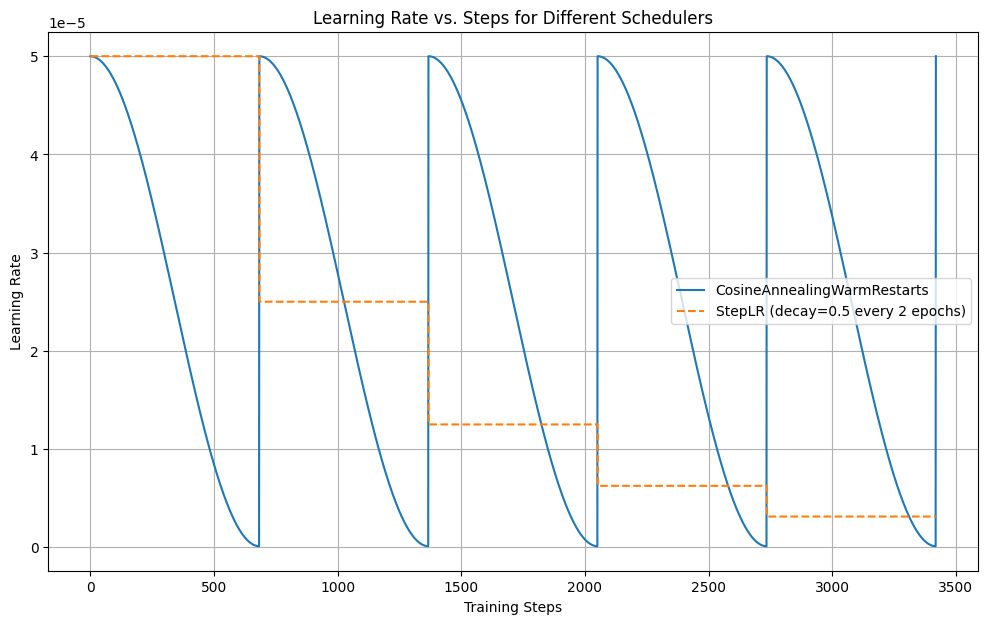

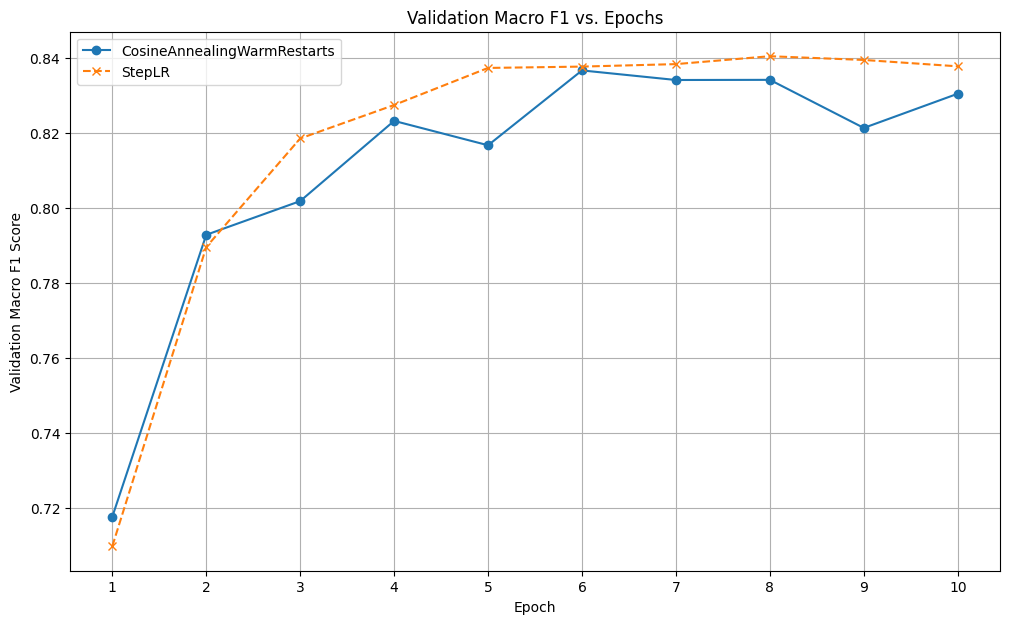

In [1]:
"""
This script performs Task 5: Comparing Learning Rate Schedulers.

This version uses a MANUAL PyTorch training loop instead of the
Hugging Face Trainer to avoid all deadlocking/hanging bugs.

It does the following:
1.  Loads a simple 80/20 train/val split.
2.  Creates PyTorch DataLoaders.
3.  Defines a main 'run_experiment' function that takes a scheduler type.
4.  Inside the function, it manually trains the model for 10 epochs,
    handles all optimizer/scheduler steps, and logs LR and Macro F1.
5.  Runs the experiment for 'cosine_with_restarts'.
6.  Runs the experiment for 'step'.
7.  Generates the two comparison plots.
"""

import os
import pandas as pd
import numpy as np
import torch
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

from datasets import Dataset
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification
)
from torch.optim import AdamW
from torch.optim.lr_scheduler import (
    CosineAnnealingWarmRestarts,
    StepLR
)

# Suppress Hugging Face's tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Suppress the PyTorch UserWarning
warnings.filterwarnings(
    "ignore",
    message="Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector."
)

# --- 1. Configuration ---
print("--- Section 1: Configuration ---")

config = {
    "MODEL_NAME": "bert-base-uncased",
    "TRAIN_FILE": "/kaggle/input/2025-sep-dl-gen-ai-project/train.csv",
    "RANDOM_SEED": 42,
    "VALIDATION_SPLIT_SIZE": 0.2, # 80/20 split
    "MAX_TOKEN_LENGTH": 128,
    "TRAIN_BATCH_SIZE": 16,
    "EVAL_BATCH_SIZE": 32,
    "EPOCHS": 10, # As requested for this task
    "STARTING_LR": 5e-5, # A good starting LR
}

# Define the labels for the task
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']
label2id = {label: i for i, label in enumerate(emotion_labels)}
id2label = {i: label for i, label in enumerate(emotion_labels)}
num_labels = len(emotion_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Load and Prepare Data ---
print("\n--- Section 2: Load and Prepare Data ---")

train_df = pd.read_csv(config["TRAIN_FILE"])
df_train, df_val = train_test_split(
    train_df,
    test_size=config["VALIDATION_SPLIT_SIZE"],
    random_state=config["RANDOM_SEED"]
)

print(f"Training split shape: {df_train.shape}")
print(f"Validation split shape: {df_val.shape}")

# --- 3. Tokenizer and PyTorch Datasets ---
print("\n--- Section 3: Tokenization & PyTorch Datasets ---")
tokenizer = AutoTokenizer.from_pretrained(config["MODEL_NAME"])

def preprocess_function(batch_texts, batch_labels):
    """Tokenizes text and returns a dict for the model."""
    tokenized_inputs = tokenizer(
        batch_texts,
        truncation=True,
        padding="max_length",
        max_length=config["MAX_TOKEN_LENGTH"],
        return_tensors="pt"
    )
    
    # Convert labels to a tensor
    labels_tensor = torch.tensor(batch_labels, dtype=torch.float)
    
    return {
        "input_ids": tokenized_inputs["input_ids"],
        "attention_mask": tokenized_inputs["attention_mask"],
        "labels": labels_tensor
    }

class EmotionDataset(TorchDataset):
    """Custom PyTorch dataset."""
    def __init__(self, df):
        self.texts = df['text'].tolist()
        self.labels = df[emotion_labels].values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_fn(batch):
    """Custom collate function to batch-tokenize."""
    texts, labels = zip(*batch)
    return preprocess_function(list(texts), list(labels))

# Create DataLoaders
train_dataset = EmotionDataset(df_train)
val_dataset = EmotionDataset(df_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=config["TRAIN_BATCH_SIZE"],
    collate_fn=collate_fn,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["EVAL_BATCH_SIZE"],
    collate_fn=collate_fn,
    shuffle=False
)

steps_per_epoch = len(train_loader)
print(f"Steps per epoch: {steps_per_epoch}")

# --- 4. Helper Functions (Evaluate) ---
print("\n--- Section 4: Defining Helper Functions ---")

def evaluate(model, dataloader):
    """Runs evaluation and returns Macro F1 Score."""
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): # No gradients needed
        for batch in dataloader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Get model outputs
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Convert logits to 0/1 predictions
            sigmoid = torch.sigmoid(logits)
            predictions = (sigmoid > 0.5).int()
            
            all_preds.append(predictions.cpu())
            all_labels.append(labels.cpu())
            
    # Concatenate all results
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    
    # Calculate Macro F1
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return macro_f1

# --- 5. Main Experiment Function ---
print("\n--- Section 5: Defining Main Experiment Function ---")

def run_experiment(scheduler_name: str):
    """
    Trains a model for 10 epochs using the specified scheduler.
    Returns logs for LR vs. Steps and F1 vs. Epochs.
    """
    print(f"\n--- Starting Experiment: {scheduler_name} ---")
    
    # Initialize a fresh model and optimizer
    model = AutoModelForSequenceClassification.from_pretrained(
        config["MODEL_NAME"],
        num_labels=num_labels,
        problem_type="multi_label_classification"
    ).to(device)
    
    optimizer = AdamW(model.parameters(), lr=config["STARTING_LR"])
    
    # Initialize the correct scheduler
    if scheduler_name == "cosine_with_restarts":
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=steps_per_epoch * 2, # Restart every 2 epochs (in steps)
            eta_min=1e-7
        )
        step_per_batch = True # This scheduler steps every batch
    
    elif scheduler_name == "step":
        scheduler = StepLR(
            optimizer,
            step_size=2, # Decay every 2 epochs
            gamma=0.5    # Halve the learning rate
        )
        step_per_batch = False # This scheduler steps every epoch
    
    else:
        raise ValueError("Unknown scheduler name")
        
    # --- Logging lists ---
    lr_log = [] # (step, lr)
    f1_log = [] # (epoch, f1)
    global_step = 0
    
    # --- Training Loop ---
    for epoch in range(config["EPOCHS"]):
        print(f"  Starting Epoch {epoch+1}/{config['EPOCHS']}")
        model.train() # Set model to training mode
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            
            # Backward pass
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()
            if step_per_batch:
                scheduler.step() # Step the scheduler
            optimizer.zero_grad() # Clear gradients
            
            # Log LR
            current_lr = scheduler.get_last_lr()[0]
            lr_log.append((global_step, current_lr))
            global_step += 1
            
        # --- End of Epoch ---
        if not step_per_batch:
            scheduler.step() # Step the scheduler (e.g., for StepLR)
            
        # Run evaluation
        print(f"  Running evaluation for Epoch {epoch+1}...")
        macro_f1 = evaluate(model, val_loader)
        f1_log.append((epoch + 1, macro_f1))
        
        print(f"  Epoch {epoch+1} - Validation Macro F1: {macro_f1:.4f}")
        
    print(f"--- Experiment {scheduler_name} Finished ---")
    return lr_log, f1_log

# --- 6. Run Both Experiments ---
print("\n--- Section 6: Running Experiments ---")

cosine_lr_logs, cosine_f1_logs = run_experiment("cosine_with_restarts")
step_lr_logs, step_f1_logs = run_experiment("step")


# --- 7. Process Logs and Plot ---
print("\n--- Section 7: Processing Logs and Plotting ---")

# Convert logs to DataFrames for easier plotting
cosine_lr_df = pd.DataFrame(cosine_lr_logs, columns=['step', 'learning_rate'])
cosine_f1_df = pd.DataFrame(cosine_f1_logs, columns=['epoch', 'eval_macro_f1'])

step_lr_df = pd.DataFrame(step_lr_logs, columns=['step', 'learning_rate'])
step_f1_df = pd.DataFrame(step_f1_logs, columns=['epoch', 'eval_macro_f1'])

# --- Plot 1: LR vs. Steps ---
print("Generating Plot 1: LR vs. Steps...")
plt.figure(figsize=(12, 7))
plt.plot(
    cosine_lr_df['step'], 
    cosine_lr_df['learning_rate'], 
    label='CosineAnnealingWarmRestarts'
)
plt.plot(
    step_lr_df['step'], 
    step_lr_df['learning_rate'], 
    label='StepLR (decay=0.5 every 2 epochs)',
    linestyle='--'
)
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs. Steps for Different Schedulers')
plt.legend()
plt.grid(True)
plt.savefig("lr_vs_steps_v2.png")
print("Plot saved as 'lr_vs_steps_v2.png'")


# --- Plot 2: Macro F1 vs. Epochs ---
print("Generating Plot 2: Macro F1 vs. Epochs...")
plt.figure(figsize=(12, 7))
plt.plot(
    cosine_f1_df['epoch'], 
    cosine_f1_df['eval_macro_f1'], 
    label='CosineAnnealingWarmRestarts',
    marker='o'
)
plt.plot(
    step_f1_df['epoch'], 
    step_f1_df['eval_macro_f1'], 
    label='StepLR',
    marker='x',
    linestyle='--'
)
plt.xlabel('Epoch')
plt.ylabel('Validation Macro F1 Score')
plt.title('Validation Macro F1 vs. Epochs')
plt.legend()
plt.grid(True)
plt.xticks(ticks=range(1, config["EPOCHS"] + 1))
plt.savefig("f1_vs_epochs_v2.png")
print("Plot saved as 'f1_vs_epochs_v2.png'")

print("\n--- Analysis complete. ---")
print("Please check the output directory for 'lr_vs_steps_v2.png' and 'f1_vs_epochs_v2.png'")

# Print final scores to help answer the analysis question
print("\nFinal Scores for Analysis:")
print(f"Cosine - Best Macro F1: {cosine_f1_df['eval_macro_f1'].max():.4f}")
print(f"StepLR - Best Macro F1: {step_f1_df['eval_macro_f1'].max():.4f}")